# Experiments - PyMC, PyStan and TFP

In this notebook we compare three probabilistic programming libraries (PyStan, PyMC and TFP) over the Palmer Penguins dataset.

## 0. Set-up

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pymc as pm
import arviz as az
import stan 
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import nest_asyncio
nest_asyncio.apply()
del nest_asyncio

In [2]:
penguins = pd.read_csv("penguins.csv")
penguins.head()

,rowid,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,1,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007
1,2,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007
2,3,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007
3,4,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN,2007
4,5,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female,2007


In [3]:
penguins = penguins.copy()[['species',
                        'bill_length_mm',
                        'bill_depth_mm',
                        'flipper_length_mm',
                        'body_mass_g']]
                        
penguins.dropna(inplace=True)
penguins.head()

,species,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g
0,Adelie,39.1,18.7,181.0,3750.0
1,Adelie,39.5,17.4,186.0,3800.0
2,Adelie,40.3,18.0,195.0,3250.0
4,Adelie,36.7,19.3,193.0,3450.0
5,Adelie,39.3,20.6,190.0,3650.0


In [4]:
train, test = train_test_split(penguins, test_size=0.3, random_state=2)

print('Train shape:', train.shape)
print('Test shape:', test.shape)

Train shape: (239, 5)
Test shape: (103, 5)


In [5]:
species = ['Adelie', 'Chinstrap']

p1 = train[train['species'].isin(species)]
y_train = ((p1['species'] == species[0])*1).values
N1=len(y_train)
ind_vars = 'flipper_length_mm'
x_train = p1[ind_vars].values.reshape((N1, 1))

In [6]:
p1 = test[test['species'].isin(species)]
y_test = ((p1['species'] == species[0])*1).values
N2=len(y_test)
ind_vars = 'flipper_length_mm'
x_test = p1[ind_vars].values.reshape((N2, 1))

In [7]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape, N1, N2

((160, 1), (160,), (59, 1), (59,), 160, 59)

In [8]:
K = 1

In [9]:
def classify(x, alpha, beta, threshold):
    """
    A simple classifying function
    """
    mu = alpha + beta * x
    prob = 1 / (1 + np.exp(-mu))
    return prob, (prob > threshold).flatten()

### sklearn

In [10]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0).fit(x_train, y_train)
print("Accuracy in train set: {}".format(clf.score(x_train, y_train)))
print("Accuracy in test set: {}".format(clf.score(x_test, y_test)))

Accuracy in train set: 0.75625
Accuracy in test set: 0.6610169491525424


In [11]:
alpha_sklearn = clf.intercept_
beta_sklearn = clf.coef_
print("Estimated parameters: alpha = {}, beta={}".format(alpha_sklearn, beta_sklearn))

Estimated parameters: alpha = [31.01558028], beta=[[-0.15696072]]


In [13]:
probs, y_hat_sklearn = classify(x_test, alpha_sklearn, beta_sklearn, 0.5)

### Pymc

In [14]:
start_time = time.time()
with pm.Model() as model_train:
    alpha = pm.Normal('alpha', mu=0, sigma=10)
    beta = pm.Normal('beta', mu=0, sigma=1, shape=K)
    mu = alpha + pm.math.dot(x_train, beta)
    theta = pm.Deterministic('theta', 1 / (1 + pm.math.exp(-mu)))
    bd = pm.Deterministic('bd', -alpha/beta)
    yl = pm.Bernoulli('yl', p=theta, observed=y_train)
    start = pm.find_MAP()
    step = pm.NUTS()
    trace_train = pm.sample(5000, step, start, tune=2000)
tot_time = time.time() - start_time
print("PyMC execution time: {}".format(tot_time))

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha, beta]


Sampling 2 chains for 2_000 tune and 5_000 draw iterations (4_000 + 10_000 draws total) took 91 seconds.
The acceptance probability does not match the target. It is 0.8859, but should be close to 0.8. Try to increase the number of tuning steps.


PyMC execution time: 107.32956433296204


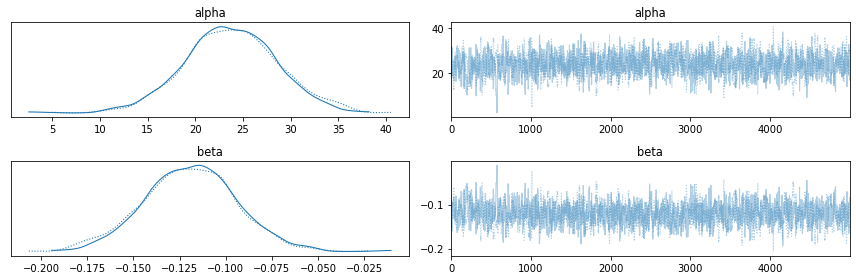

In [15]:
plots = az.plot_trace(trace_train, ['alpha','beta'])
plt.tight_layout()
plt.show()

In [16]:
trace_pymc_train = {}

theta_mc = np.array(trace_train.posterior['theta'])
trace_pymc_train['theta'] = theta_mc.reshape(theta_mc.shape[0]*theta_mc.shape[1], theta_mc.shape[2])
trace_pymc_train['bd'] = np.array(trace_train.posterior['bd']).flatten()

In [17]:
alpha_pymc = np.mean(np.array(trace_train.posterior['alpha']).flatten())

In [18]:
beta_pymc = np.mean(np.array(trace_train.posterior['beta']).flatten())

In [19]:
beta_pymc, alpha_pymc

(-0.11938912639725498, 23.742622744637558)

In [20]:
probs, y_hat_pymc = classify(x_test, alpha_pymc, beta_pymc, 0.5)
probs, y_hat_pymc_out = classify(x_train, alpha_pymc, beta_pymc, 0.5)

In [21]:
print("Accuracy in train set: {}".format(accuracy_score(y_hat_pymc_out, y_train)))
print("Accuracy in test set: {}".format(accuracy_score(y_hat_pymc, y_test)))

Accuracy in train set: 0.7375
Accuracy in test set: 0.711864406779661


### PyStan

In [51]:
code = """                                                                                         
data {                                                                                               
  int N; //the number observations  
  int K; //the number of features                                                                    
  int y[N]; //the response                                                                           
  matrix[N,K] X; //the model matrix 
}                                                                                                    
parameters {                                                                                         
  real alpha;                                                                                        
  vector[K] beta; //the regression parameters                                                        
}                                                                                                    
transformed parameters {                                                                             
  vector[N] linpred;                                                                                 
  linpred = alpha+X*beta; 
  #vector[N] bd;
  #bd = -alpha/beta;
}                                                                                                    
model {                                                                                              
  alpha ~ normal(0,10); //prior for the intercept following Gelman 2008                              
                                                                                                   
  for(i in 1:K)                                                                                      
    beta[i] ~ normal(0,10);                                                                 
                                                                                                   
  y ~ bernoulli_logit(linpred);                                                                      
}
"""  

In [52]:
data = {                                                                                             
    'N': N1,
    'K': K,                                                                                        
    'y': y_train,                                                                                     
    'X': x_train, 
}  

In [53]:
posterior = stan.build(code, data=data, random_seed=1)

Building: 0.3s
Building: 0.4s
Building: 0.5s
Building: 0.6s
Building: 0.7s
Building: 0.9s
Building: 1.0s
Building: 1.1s
Building: 1.2s
Building: 1.3s
Building: 1.4s
Building: 1.5s
Building: 1.6s
Building: 1.7s
Building: 1.8s
Building: 1.9s
Building: 2.0s
Building: 2.2s
Building: 2.3s
Building: 2.4s
Building: 2.5s
Building: 2.6s
Building: 2.7s
Building: 2.8s
Building: 2.9s
Building: 3.0s
Building: 3.1s
Building: 3.3s
Building: 3.4s
Building: 3.5s
Building: 3.6s
Building: 3.7s
Building: 3.8s
Building: 3.9s
Building: 4.0s
Building: 4.1s
Building: 4.2s
Building: 4.3s
Building: 4.4s
Building: 4.6s
Building: 4.7s
Building: 4.8s
Building: 4.9s
Building: 5.0s
Building: 5.1s
Building: 5.2s
Building: 5.3s
Building: 5.4s
Building: 5.5s
Building: 5.6s
Building: 5.7s
Building: 5.8s
Building: 6.0s
Building: 6.1s
Building: 6.2s
Building: 6.3s
Building: 6.4s
Building: 6.5s
Building: 6.6s
Building: 6.7s
Building: 6.8s
Building: 6.9s
Building: 7.0s


In file included from /Users/claudiahm/Library/Caches/httpstan/4.7.2/models/cukhrh7v/model_cukhrh7v.cpp:2:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:8:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/rev/core.hpp:28:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/rev/core/operator_addition.hpp:6:
/usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/prim/err/check_matching_dims.hpp:33:8: warning: unused variable 'error' [-Wunused-variable]
  bool error = false;
       ^
/usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/prim/err/check_matching_dims.hpp:57:23: warning: comparison of integers of different signs: 'int' and 'std:

Building: 7.1s
Building: 7.2s
Building: 7.4s
Building: 7.5s
Building: 7.6s
Building: 7.7s
Building: 7.8s
Building: 7.9s


In file included from /Users/claudiahm/Library/Caches/httpstan/4.7.2/models/cukhrh7v/model_cukhrh7v.cpp:2:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:8:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/rev/core.hpp:53:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/rev/core/profiling.hpp:9:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/prim/err.hpp:50:
/usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/prim/err/hmm_check.hpp:33:7: warning: unused variable 'n_transitions' [-Wunused-variable]
  int n_transitions = log_omegas.cols() - 1;
      ^


Building: 8.0s
Building: 8.1s
Building: 8.2s
Building: 8.3s
Building: 8.4s
Building: 8.6s
Building: 8.7s
Building: 8.8s
Building: 8.9s
Building: 9.0s
Building: 9.1s
Building: 9.2s
Building: 9.3s
Building: 9.4s
Building: 9.5s
Building: 9.6s
Building: 9.8s
Building: 9.9s
Building: 10.0s
Building: 10.1s


In file included from /Users/claudiahm/Library/Caches/httpstan/4.7.2/models/cukhrh7v/model_cukhrh7v.cpp:2:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:10:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun.hpp:26:
/usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun/beta.hpp:70:32: warning: lambda capture 'b' is not used [-Wunused-lambda-capture]
                           [a, b, digamma_ab](auto& vi) mutable {
                             ~~^
/usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun/beta.hpp:96:39: warning: lambda capture 'a' is not used [-Wunused-lambda-capture]
  return make_callback_var(beta_val, [a, b, digamma_ab](auto& vi) mutable

Building: 10.2s
Building: 10.3s
Building: 10.4s
Building: 10.5s
Building: 10.6s
Building: 10.7s
Building: 10.8s
Building: 11.0s
Building: 11.1s
Building: 11.2s
Building: 11.3s
Building: 11.4s
Building: 11.5s
Building: 11.6s


In file included from /Users/claudiahm/Library/Caches/httpstan/4.7.2/models/cukhrh7v/model_cukhrh7v.cpp:2:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:10:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun.hpp:55:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun/elt_multiply.hpp:9:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun/multiply.hpp:7:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/prim/fun.hpp:121:
/usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/prim/fun/gp_matern52_cov.hpp:304:10: warning: unused variable 'neg_root_5' [-Wunused

Building: 11.7s
Building: 11.8s
Building: 11.9s
Building: 12.0s


In file included from /Users/claudiahm/Library/Caches/httpstan/4.7.2/models/cukhrh7v/model_cukhrh7v.cpp:2:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:10:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun.hpp:55:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun/elt_multiply.hpp:9:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun/multiply.hpp:7:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/prim/fun.hpp:188:
/usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/prim/fun/log_mix.hpp:86:13: warning: unused variable 'N' [-Wunused-variable]
  const

Building: 12.1s
Building: 12.3s
Building: 12.4s
Building: 12.5s
Building: 12.6s
Building: 12.7s
Building: 12.8s
Building: 12.9s
Building: 13.0s
Building: 13.1s
Building: 13.2s
Building: 13.3s
Building: 13.4s
Building: 13.5s
Building: 13.7s


In file included from /Users/claudiahm/Library/Caches/httpstan/4.7.2/models/cukhrh7v/model_cukhrh7v.cpp:2:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:10:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun.hpp:124:
/usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun/matrix_power.hpp:52:24: warning: comparison of integers of different signs: 'size_t' (aka 'unsigned long') and 'const int' [-Wsign-compare]
  for (size_t i = 2; i <= n; ++i) {
                     ~ ^  ~
In file included from /Users/claudiahm/Library/Caches/httpstan/4.7.2/models/cukhrh7v/model_cukhrh7v.cpp:2:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/model/model_hea

Building: 13.8s
Building: 13.9s
Building: 14.0s
Building: 14.1s


In file included from /Users/claudiahm/Library/Caches/httpstan/4.7.2/models/cukhrh7v/model_cukhrh7v.cpp:2:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:10:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun.hpp:158:
/usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun/simplex_constrain.hpp:40:30: warning: comparison of integers of different signs: 'Eigen::Index' (aka 'long') and 'size_t' (aka 'unsigned long') [-Wsign-compare]
  for (Eigen::Index k = 0; k < N; ++k) {
                           ~ ^ ~
/usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun/simplex_constrain.hpp:94:30: warning: comparison of integers of different signs: 'Eigen::Index' (aka

Building: 14.2s
Building: 14.3s
Building: 14.4s
Building: 14.5s
Building: 14.6s
Building: 14.7s
Building: 14.8s
Building: 14.9s
Building: 15.1s
Building: 15.2s
Building: 15.3s
Building: 15.4s
Building: 15.5s
Building: 15.6s
Building: 15.7s
Building: 15.8s
Building: 15.9s
Building: 16.0s
Building: 16.1s
Building: 16.2s
Building: 16.3s
Building: 16.4s
Building: 16.6s
Building: 16.7s
Building: 16.8s
Building: 16.9s
Building: 17.0s
Building: 17.1s
Building: 17.2s
Building: 17.3s
Building: 17.4s
Building: 17.5s
Building: 17.6s
Building: 17.7s
Building: 17.9s
Building: 18.0s
Building: 18.1s
Building: 18.2s
Building: 18.3s
Building: 18.4s
Building: 18.5s
Building: 18.6s
Building: 18.7s
Building: 18.8s
Building: 18.9s
Building: 19.0s
Building: 19.1s
Building: 19.3s
Building: 19.4s
Building: 19.5s
Building: 19.6s
Building: 19.7s
Building: 19.8s
Building: 19.9s
Building: 20.0s
Building: 20.1s


In file included from /Users/claudiahm/Library/Caches/httpstan/4.7.2/models/cukhrh7v/model_cukhrh7v.cpp:2:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:11:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/rev/functor.hpp:16:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/rev/functor/dae.hpp:5:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/rev/functor/idas_integrator.hpp:5:
/usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/rev/functor/idas_service.hpp:93:28: warning: comparison of integers of different signs: 'size_t' (aka 'unsigned long') and 'int' [-Wsign-compare]
    for (size_t is = 0; is < ns; +

Building: 20.2s
Building: 20.3s
Building: 20.4s
Building: 20.6s
Building: 20.7s
Building: 20.8s


In file included from /Users/claudiahm/Library/Caches/httpstan/4.7.2/models/cukhrh7v/model_cukhrh7v.cpp:2:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:13:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/prim.hpp:16:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/prim/prob.hpp:87:
/usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/prim/prob/double_exponential_cdf.hpp:77:10: warning: unused variable 'N' [-Wunused-variable]
  size_t N = max_size(y, mu, sigma);
         ^


Building: 20.9s
Building: 21.0s


In file included from /Users/claudiahm/Library/Caches/httpstan/4.7.2/models/cukhrh7v/model_cukhrh7v.cpp:2:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:13:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/prim.hpp:16:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/prim/prob.hpp:128:
/usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/prim/prob/gaussian_dlm_obs_rng.hpp:41:21: warning: comparison of integers of different signs: 'int' and 'size_t' (aka 'unsigned long') [-Wsign-compare]
  for (int i = 0; i < M; i++) {
                  ~ ^ ~
/usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/prim/prob/gaussian_dlm_obs_rng.hpp:98:7:

Building: 21.1s
Building: 21.2s
Building: 21.3s
Building: 21.4s
Building: 21.5s


In file included from /Users/claudiahm/Library/Caches/httpstan/4.7.2/models/cukhrh7v/model_cukhrh7v.cpp:2:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:13:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/prim.hpp:16:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/prim/prob.hpp:139:
/usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/prim/prob/hmm_marginal.hpp:26:13: warning: unused variable 'n_states' [-Wunused-variable]
  const int n_states = omegas.rows();
            ^


Building: 21.6s
Building: 21.7s
Building: 21.8s
Building: 22.0s
Building: 22.1s
Building: 22.2s
Building: 22.3s
Building: 22.4s
Building: 22.5s
Building: 22.6s
Building: 22.7s
Building: 22.8s
Building: 22.9s


In file included from /Users/claudiahm/Library/Caches/httpstan/4.7.2/models/cukhrh7v/model_cukhrh7v.cpp:2:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:13:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/prim.hpp:16:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/prim/prob.hpp:308:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/prim/prob/skew_double_exponential_ccdf_log.hpp:5:
/usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/prim/prob/skew_double_exponential_lccdf.hpp:78:13: warning: unused variable 'size_sigma' [-Wunused-variable]
  const int size_sigma = stan::math::size(sigma);
            ^
In 

Building: 23.0s
Building: 23.2s
Building: 23.3s
Building: 23.4s


In file included from /Users/claudiahm/Library/Caches/httpstan/4.7.2/models/cukhrh7v/model_cukhrh7v.cpp:2:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:7:
/usr/local/lib/python3.9/site-packages/httpstan/include/stan/io/dump.hpp:694:52: warning: comparison of integers of different signs: 'int' and 'std::__1::vector<double>::size_type' (aka 'unsigned long') [-Wsign-compare]
      for (comp_iter = 0, real_iter = 0; real_iter < val_r->second.first.size();
                                         ~~~~~~~~~ ^ ~~~~~~~~~~~~~~~~~~~~~~~~~~
/usr/local/lib/python3.9/site-packages/httpstan/include/stan/io/dump.hpp:707:24: warning: comparison of integers of different signs: 'int' and 'std::__1::vector<int>::size_type' (aka 'unsigned long') [-Wsign-compare]
             real_iter < val_i->second.first.size();
             ~~~~~~~~~ ^ ~~~~~~~~~~~~~~~~~~~~~~~~~~
In file included from /Users/claudiahm/Library/Caches/httpstan/4.7.2/models/cukhr

Building: 23.5s
Building: 23.6s
Building: 23.7s


In file included from /Users/claudiahm/Library/Caches/httpstan/4.7.2/models/cukhrh7v/model_cukhrh7v.cpp:2:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:17:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/model/indexing.hpp:6:
/usr/local/lib/python3.9/site-packages/httpstan/include/stan/model/indexing/assign.hpp:274:21: warning: comparison of integers of different signs: 'int' and 'std::__1::vector<int>::size_type' (aka 'unsigned long') [-Wsign-compare]
  for (int i = 0; i < idx.ns_.size(); ++i) {
                  ~ ^ ~~~~~~~~~~~~~~
/usr/local/lib/python3.9/site-packages/httpstan/include/stan/model/indexing/assign.hpp:528:21: warning: comparison of integers of different signs: 'int' and 'std::__1::vector<int>::size_type' (aka 'unsigned long') [-Wsign-compare]
  for (int i = 0; i < col_idx.ns_.size(); ++i) {
                  ~ ^ ~~~~~~~~~~~~~~~~~~
/usr/local/lib/python3.9/site-packages/https

Building: 23.8s
Building: 23.9s
Building: 24.0s
Building: 24.1s
Building: 24.2s
Building: 24.3s
Building: 24.5s
Building: 24.6s
Building: 24.7s
Building: 24.8s
Building: 24.9s
Building: 25.0s


In file included from /Users/claudiahm/Library/Caches/httpstan/4.7.2/models/cukhrh7v/model_cukhrh7v.cpp:2:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:8:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/rev/core.hpp:29:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/rev/core/operator_divide_equal.hpp:5:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/rev/core/operator_division.hpp:14:
/usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/rev/core/operator_subtraction.hpp:84:21: warning: lambda capture 'b' is not used [-Wunused-lambda-capture]
      [avi = a.vi_, b](const auto& vi) mutable { avi->adj_ += 

Building: 25.1s
Building: 25.2s
Building: 25.3s
Building: 25.4s
Building: 25.6s
Building: 25.7s
Building: 25.8s
Building: 25.9s
Building: 26.0s
Building: 26.1s
Building: 26.2s
Building: 26.3s
Building: 26.5s
Building: 26.6s
Building: 26.7s
Building: 26.8s
Building: 26.9s


In file included from /Users/claudiahm/Library/Caches/httpstan/4.7.2/models/cukhrh7v/model_cukhrh7v.cpp:2:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:8:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/rev/core.hpp:28:
/usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/rev/core/operator_addition.hpp:80:21: warning: lambda capture 'b' is not used [-Wunused-lambda-capture]
      [avi = a.vi_, b](const auto& vi) mutable { avi->adj_ += vi.adj_; });
                    ^
/usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun/grad_inc_beta.hpp:45:43: note: in instantiation of function template specialization 'stan::math::operator+<int, nullptr>' requested here
    gr

Building: 27.0s
Building: 27.1s


In file included from /Users/claudiahm/Library/Caches/httpstan/4.7.2/models/cukhrh7v/model_cukhrh7v.cpp:2:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:8:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/rev/core.hpp:28:
/usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/rev/core/operator_addition.hpp:80:21: warning: lambda capture 'b' is not used [-Wunused-lambda-capture]
      [avi = a.vi_, b](const auto& vi) mutable { avi->adj_ += vi.adj_; });
                    ^
/usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/prim/fun/trigamma.hpp:63:31: note: in instantiation of function template specialization 'stan::math::operator+<double, nullptr>' requested here
    val

Building: 27.2s
Building: 27.3s
Building: 27.4s
Building: 27.5s
Building: 27.7s
Building: 27.8s
Building: 27.9s
Building: 28.0s
Building: 28.1s
Building: 28.2s
Building: 28.3s
Building: 28.4s


In file included from /Users/claudiahm/Library/Caches/httpstan/4.7.2/models/cukhrh7v/model_cukhrh7v.cpp:2:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:8:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/rev/core.hpp:53:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/rev/core/profiling.hpp:9:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/prim/err.hpp:4:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/prim/err/check_2F1_converges.hpp:5:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/prim/err/check_not_nan.hpp:5:
/usr/local/lib/python3.9

Building: 28.5s
Building: 28.6s
Building: 28.7s
Building: 28.8s
Building: 29.0s
Building: 29.1s
Building: 29.2s
Building: 29.3s
Building: 29.4s
Building: 29.5s


In file included from /Users/claudiahm/Library/Caches/httpstan/4.7.2/models/cukhrh7v/model_cukhrh7v.cpp:2:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:8:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/rev/core.hpp:53:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/rev/core/profiling.hpp:9:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/prim/err.hpp:4:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/prim/err/check_2F1_converges.hpp:5:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/prim/err/check_not_nan.hpp:5:
/usr/local/lib/python3.9

Building: 29.6s
Building: 29.7s


In file included from /Users/claudiahm/Library/Caches/httpstan/4.7.2/models/cukhrh7v/model_cukhrh7v.cpp:2:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:8:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/rev/core.hpp:58:
/usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/rev/core/set_zero_all_adjoints.hpp:14:13: warning: 'static' function 'set_zero_all_adjoints' declared in header file should be declared 'static inline' [-Wunneeded-internal-declaration]
static void set_zero_all_adjoints() {
            ^
In file included from /Users/claudiahm/Library/Caches/httpstan/4.7.2/models/cukhrh7v/model_cukhrh7v.cpp:2:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/inc

Building: 29.8s
Building: 29.9s
Building: 30.0s
Building: 30.2s
Building: 30.3s
Building: 30.4s
Building: 30.5s
Building: 30.6s
Building: 30.7s
Building: 30.8s
Building: 30.9s
Building: 31.0s
Building: 31.1s
Building: 31.2s
Building: 31.3s
Building: 31.4s
Building: 31.6s
Building: 31.7s
Building: 31.8s
Building: 31.9s
Building: 32.0s
Building: 32.1s
Building: 32.2s
Building: 32.3s
Building: 32.4s
Building: 32.5s
Building: 32.6s
Building: 32.8s
Building: 32.9s
Building: 33.0s
Building: 33.1s
Building: 33.2s
Building: 33.3s
Building: 33.4s
Building: 33.6s
Building: 33.7s
Building: 33.8s
Building: 33.9s
Building: 34.0s
Building: 34.1s
Building: 34.3s
Building: 34.4s
Building: 34.5s
Building: 34.7s
Building: 34.8s
Building: 34.9s
Building: 35.0s
Building: 35.1s
Building: 35.3s
Building: 35.4s
Building: 35.5s
Building: 35.6s
Building: 35.7s
Building: 35.9s
Building: 36.0s
Building: 36.1s
Building: 36.2s
Building: 36.3s
Building: 36.4s
Building: 36.6s
Building: 36.7s
Building: 36.8s
Building

62 warnings generated.


Building: 46.4s
Building: 46.5s
Building: 46.6s


ld: warning: direct access in function 'long double boost::math::detail::bessel_j0<long double>(long double)' from file '/usr/local/lib/python3.9/site-packages/httpstan/stan_services.o' to global weak symbol 'long double boost::math::detail::bessel_j0<long double>(long double)::Q2' from file 'build/temp.macosx-11-x86_64-3.9/Users/claudiahm/Library/Caches/httpstan/4.7.2/models/cukhrh7v/model_cukhrh7v.o' means the weak symbol cannot be overridden at runtime. This was likely caused by different translation units being compiled with different visibility settings.
ld: warning: direct access in function 'long double boost::math::detail::bessel_j0<long double>(long double)' from file '/usr/local/lib/python3.9/site-packages/httpstan/stan_services.o' to global weak symbol 'long double boost::math::detail::bessel_j0<long double>(long double)::P2' from file 'build/temp.macosx-11-x86_64-3.9/Users/claudiahm/Library/Caches/httpstan/4.7.2/models/cukhrh7v/model_cukhrh7v.o' means the weak symbol cannot

Messages from stanc:
Warning in '/var/folders/79/lndg0b5n2q3b40m_ty2kxlm40000gn/T/httpstan_q7mo9amm/model_cukhrh7v.stan', line 5, column 2: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/var/folders/79/lndg0b5n2q3b40m_ty2kxlm40000gn/T/httpstan_q7mo9amm/model_cukhrh7v.stan', line 15, column 2: Comments
    beginning with # are deprecated and this syntax will be removed in Stan
    2.32.0. Use // to begin line comments; this can be done automatically
    using the auto-format flag to stanc
Warning in '/var/folders/79/lndg0b5n2q3b40m_ty2kxlm40000gn/T/httpstan_q7mo9amm/model_cukhrh7v.stan', line 16, column 2: Comments
    beginning with # are deprecated and this syntax will be removed in Stan
    2.32.0. Use // to begin line comments; this can be done automatically
    using the a

In [54]:
start_time = time.time()
fit = posterior.sample(num_chains=2, num_samples=1000)
tot_time = time.time() - start_time
print("PyStan execution time: {}".format(tot_time))

Sampling:   0%
Sampling:   0% (1/4000)
Sampling:   0% (2/4000)
Sampling:   3% (101/4000)
Sampling:   5% (200/4000)
Sampling:  12% (500/4000)
Sampling:  15% (600/4000)
Sampling:  18% (700/4000)
Sampling:  22% (900/4000)
Sampling:  28% (1100/4000)
Sampling:  35% (1400/4000)
Sampling:  68% (2700/4000)
Sampling: 100% (4000/4000)
Sampling: 100% (4000/4000), done.
Messages received during sampling:
  Gradient evaluation took 0.000146 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.46 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000293 seconds
  1000 transitions using 10 leapfrog steps per transition would take 2.93 seconds.
  Adjust your expectations accordingly!


PyStan execution time: 4.207807779312134


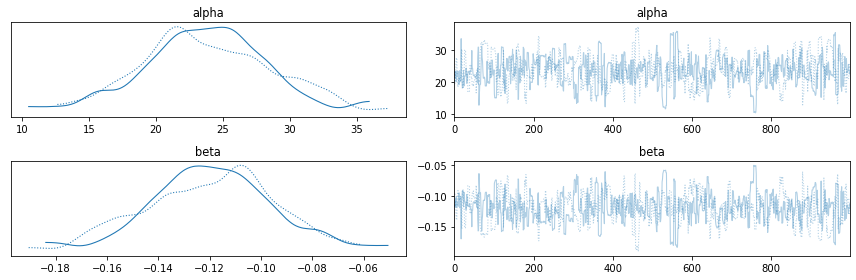

In [55]:
varnames = ['alpha', 'beta']
az.plot_trace(fit, varnames)
plt.tight_layout()
plt.show()

In [56]:
alpha_pystan = np.mean(fit['alpha'])
beta_pystan = np.mean(fit['beta'])
alpha_pystan, beta_pystan

(23.736711536642996, -0.11934282783618227)

In [57]:
probs, y_hat_pystan = classify(x_test, alpha_pystan, beta_pystan, 0.5)
probs, y_hat_pystan_out = classify(x_train, alpha_pystan, beta_pystan, 0.5)

In [58]:
print("Accuracy in train set: {}".format(accuracy_score(y_hat_pystan_out, y_train)))
print("Accuracy in test set: {}".format(accuracy_score(y_hat_pystan, y_test)))

Accuracy in train set: 0.7375
Accuracy in test set: 0.711864406779661
